In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

df = pd.read_csv('../data/experiments/assessment/v2/assessments_v1.csv')
df

,temperature,speed,layer,feeding_rate,width,height,area,determination
0,180,500,0,0.03,0.232047,0.113483,0.027571,0.566229
1,180,500,1,0.03,0.343069,0.186798,0.060071,0.844442
2,180,500,2,0.03,0.456030,0.214355,0.093566,0.895364
3,180,500,0,0.04,0.422093,0.141609,0.058275,0.793031
4,180,500,1,0.04,0.427048,0.181689,0.074651,0.943355
...,...,...,...,...,...,...,...,...
235,200,1200,1,0.21,1.212323,0.319786,0.358358,0.979150
236,200,1200,2,0.21,1.129647,0.294548,0.302866,0.987627
237,200,1200,0,0.22,1.231542,0.340750,0.393009,0.968387
238,200,1200,1,0.22,0.851429,0.320425,0.272002,0.976035


In [26]:
# Setup plots

SMALL_SIZE = 16
MEDIUM_SIZE = SMALL_SIZE * 1.2
BIGGER_SIZE = SMALL_SIZE * 1.5

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [27]:
print(f"{df[df.determination <= 0.7].shape[0]} (out of {df.shape[0]}) data points disconsidered because of low determination")

11 (out of 240) data points disconsidered because of low determination


## Pre processing

* Calculate gap distance
* Remove data of layer = 2

In [28]:
last_layer_height = []
for row in df.iloc:
    if row.layer == 0:
        last_layer_height.append(0)
    else:
        last_layer_height.append(df[(df.temperature == row.temperature) & (df.speed == row.speed) & (df.feeding_rate == row.feeding_rate) & (df.layer < row.layer)].height.sum())
df["last_layer_height"] = last_layer_height
df = df[df.determination > 0.7]
df['gap'] = (1 + df.layer) * 0.2 - df.last_layer_height
df = df[df.layer <= 1]
df

/var/folders/c0/l87ylxnd52v7n4kq_c122hg00000gn/T/ipykernel_7555/2155986236.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gap'] = (1 + df.layer) * 0.2 - df.last_layer_height


,temperature,speed,layer,feeding_rate,width,height,area,determination,last_layer_height,gap
1,180,500,1,0.03,0.343069,0.186798,0.060071,0.844442,0.113483,0.286517
3,180,500,0,0.04,0.422093,0.141609,0.058275,0.793031,0.000000,0.200000
4,180,500,1,0.04,0.427048,0.181689,0.074651,0.943355,0.141609,0.258391
6,180,500,0,0.05,0.462910,0.172832,0.077505,0.874186,0.000000,0.200000
7,180,500,1,0.05,0.519121,0.185009,0.091320,0.957285,0.172832,0.227168
...,...,...,...,...,...,...,...,...,...,...
232,200,1200,1,0.20,1.273103,0.311648,0.361049,0.987496,0.340510,0.059490
234,200,1200,0,0.21,1.142737,0.359291,0.382367,0.967821,0.000000,0.200000
235,200,1200,1,0.21,1.212323,0.319786,0.358358,0.979150,0.359291,0.040709
237,200,1200,0,0.22,1.231542,0.340750,0.393009,0.968387,0.000000,0.200000


## Dataset

In [29]:
X = df[["temperature", "speed", "feeding_rate", "layer", "gap", "width", "area"]].values
height = df[["height"]].values
width = df[["width"]].values
area = df[["area"]].values

# Width model

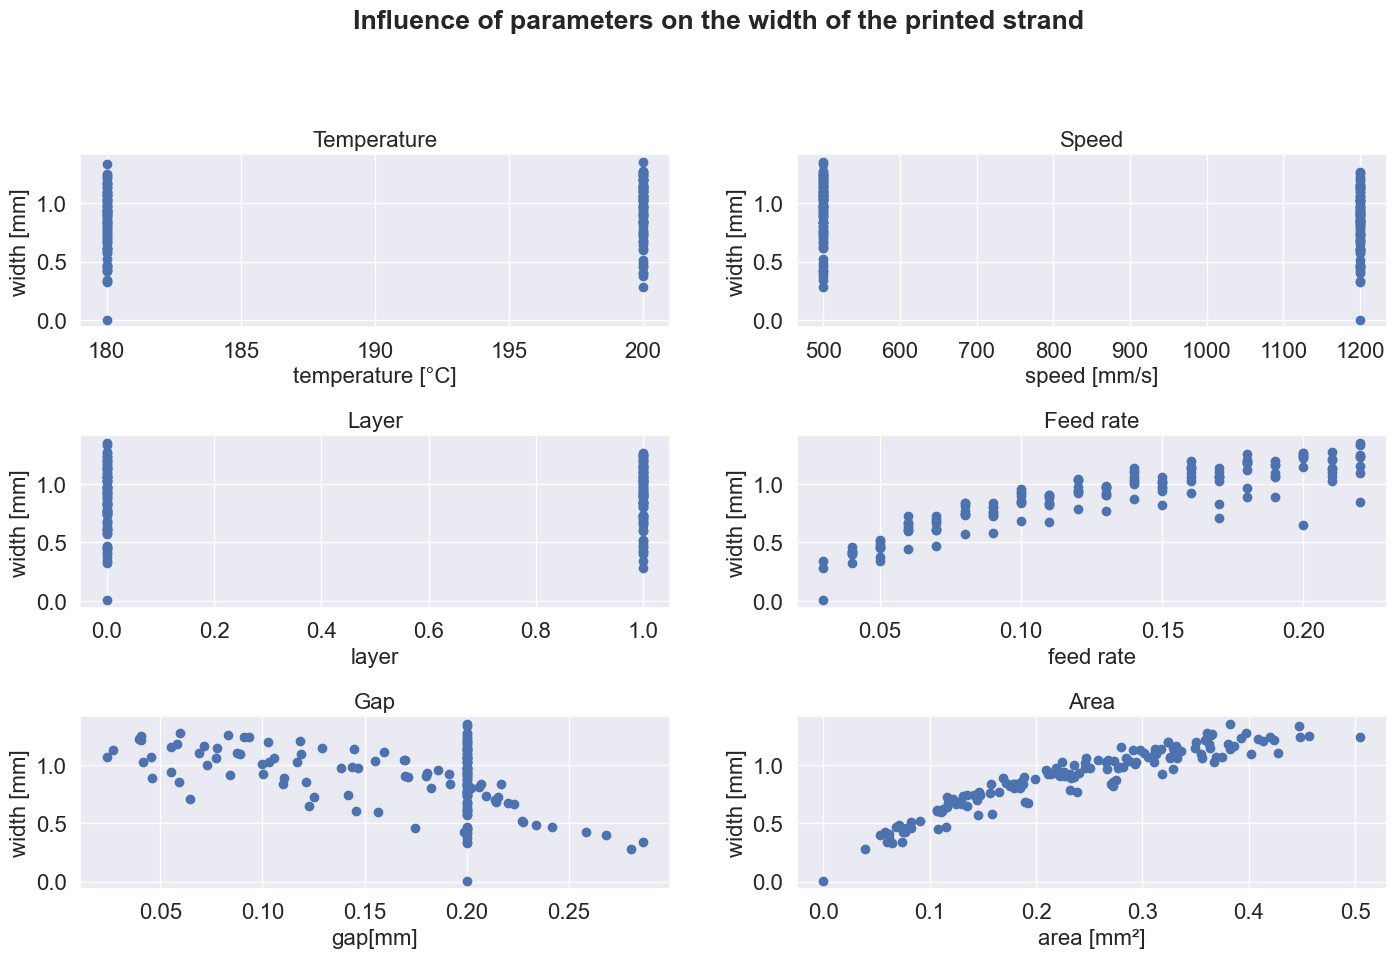

In [30]:
eval = "width"
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle("Influence of parameters on the width of the printed strand", weight="bold")
fig.tight_layout(pad=3.0)
for i, (param, unit) in enumerate(zip(["temperature", "speed", "layer", "feeding_rate", "gap", "area"], [' [°C]', ' [mm/s]', '', '', '[mm]', ' [mm²]'])):
    axes[i//2, i%2].plot(df[param], df[eval], 'o')
    if param == 'feeding_rate': param = 'feed rate'
    axes[i//2, i%2].title.set_text(f'{param[0].upper()}{param[1:]}')
    axes[i//2, i%2].set_xlabel(f"{param}{unit}")
    axes[i//2, i%2].set_ylabel(f"{eval} [mm]")

### Test of the models in the literature

In [31]:
from sklearn.metrics import r2_score

def xu(X, D=0.4, rn=1):
    t, s, f, l, g, w, a = X.T
    w = D*(1 - rn/D + np.sqrt((rn/D-1)**2 + np.pi*D*f/g * (rn/D - 0.5)**2))
    return w

predxu = xu(X)

r2 = r2_score(width, predxu)
print('Results of the model proposed by Xu et al. (2022)')
print('-'*50)
print(f"Linear Regression r^2 on test data : {r2:.3f}")
print(f"Prediction: {predxu[0]}\nReal value: {width[0][0]}")

def hebda(X, D=0.4, alpha=1.75):
    t, s, f, l, g, w, a = X.T
    w = alpha * D * np.sqrt(f)
    return w

predhebda = hebda(X)

r2 = r2_score(width, predhebda)
print('\nResults of the model proposed by Hebda et al. (2019)')
print('-'*50)
print(f"Linear Regression r^2 on test data : {r2:.3f}")
print(f"Prediction: {predhebda[0]}\nReal value: {width[0][0]}")

Results of the model proposed by Xu et al. (2022)
--------------------------------------------------
Linear Regression r^2 on test data : -2.795
Prediction: 0.06649036758114679
Real value: 0.3430693379119418

Results of the model proposed by Hebda et al. (2019)
--------------------------------------------------
Linear Regression r^2 on test data : -5.525
Prediction: 0.12124355652982143
Real value: 0.3430693379119418


## Feature Engineering

**Hypothesis**:
* As suggested by Comminal et al., the width is proportional to the square root of the feeding rate
* The layer should not matter, although the graph suggests differently
* Parameters with low coefficients can be removed from the model

In [32]:
from sklearn.preprocessing import FunctionTransformer

def feature_extraction(X:np.ndarray) -> np.ndarray:
    temperature, speed, feeding_rate, layer = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    sqrt_fr = np.sqrt(feeding_rate)
    cbrt_fr = np.cbrt(feeding_rate)
    fr2 = feeding_rate ** 2
    t_f = temperature * feeding_rate
    return np.column_stack([temperature, speed, cbrt_fr])

FeatureExtraction = FunctionTransformer(feature_extraction)

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

width_model = Pipeline([('transf', FeatureExtraction),
                        # ('poly', PolynomialFeatures(degree=3)),
                        ('linear', LinearRegression())])

width_model = width_model.fit(X, width)
pred = width_model.predict(X)
r2 = r2_score(width, pred)
print(f"Linear Regression r^2 on test data : {r2:.3f}")
print(f"Prediction: {pred[0][0]}\nReal value: {width[0][0]}")

Linear Regression r^2 on test data : 0.881
Prediction: 0.3506883578110451
Real value: 0.3430693379119418


In [34]:
def print_coefs_and_params_names(model, coef_names = ['temperature', 'speed', 'cbrt_fr']):
    linear_model = model.named_steps['linear']
    transformer = model.named_steps['transf']
    if hasattr(transformer, 'get_feature_names_out'):
        coef_names = transformer.get_feature_names_out(coef_names)
    coefficients = linear_model.coef_[0]
    
    print('Coefficients:')
    for coef_name, coef_value in zip(coef_names, coefficients):
        print(f'{coef_name}: {coef_value}')
    print(f'intercept: {linear_model.intercept_[0]}')
        
print_coefs_and_params_names(width_model)


Coefficients:
temperature: 0.004062025031923957
speed: -0.0001331731552701792
cbrt_fr: 2.984109335460154
intercept: -1.2411217231463934


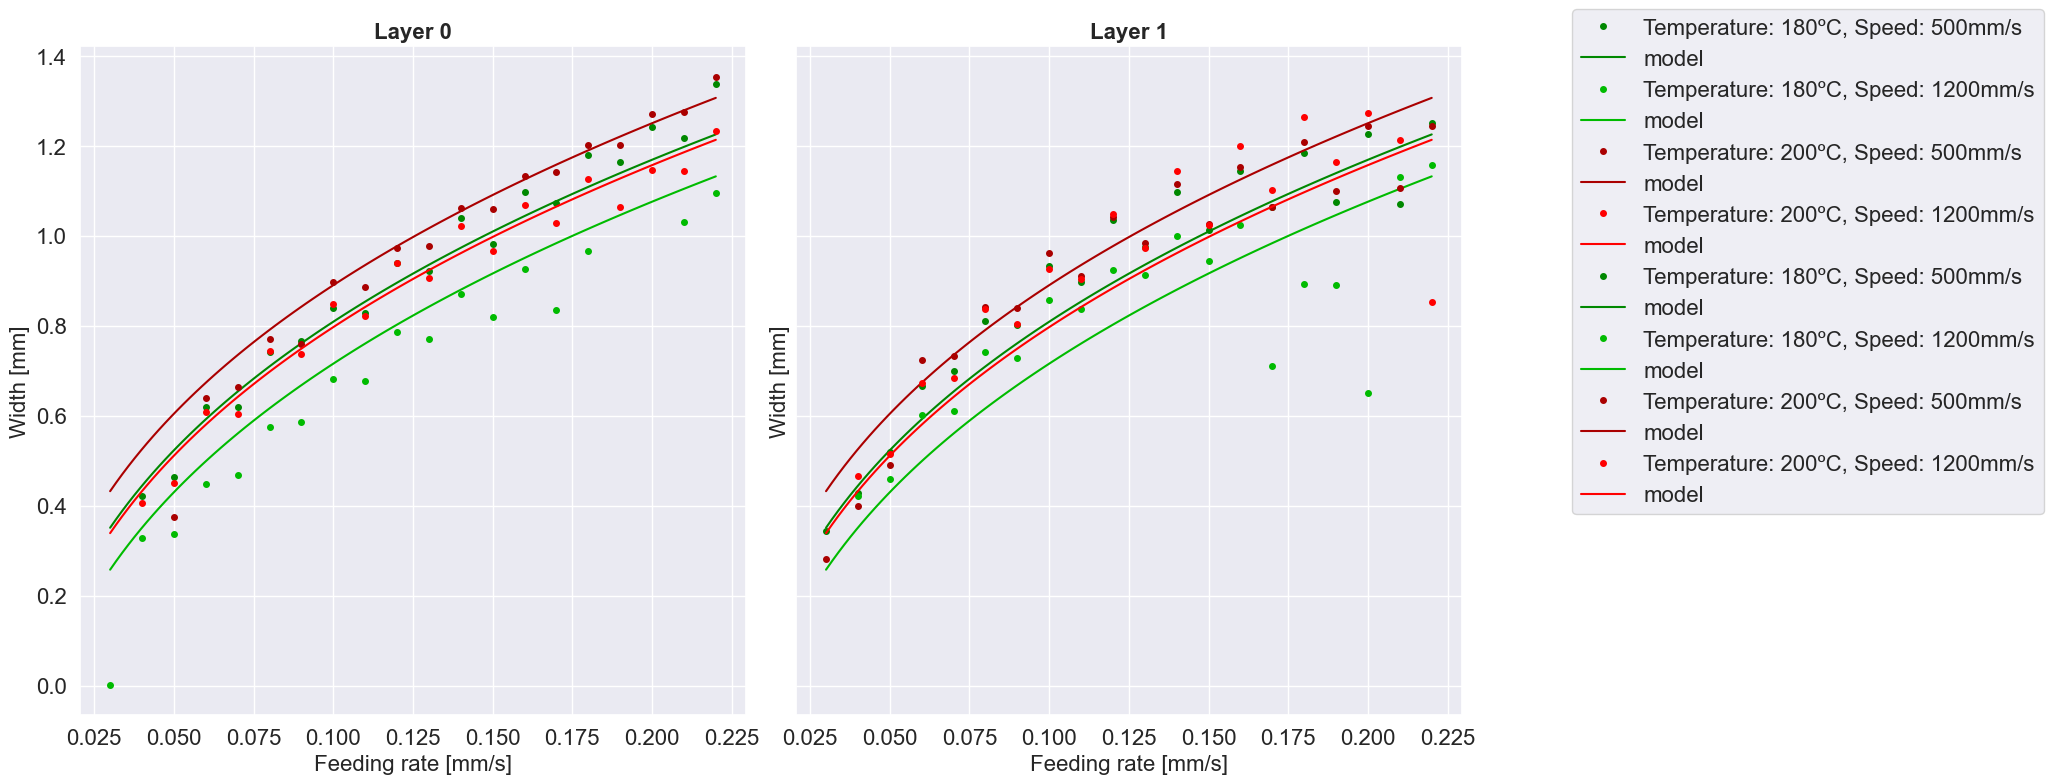

In [35]:
from itertools import product

domain = np.linspace(df.feeding_rate.min(), df.feeding_rate.max(), 100)
def my_function(domain, temp, speed):
    # return np.cbrt(domain) * 3.5 * temp/200  -0.8
    return width_model.predict(np.column_stack([np.ones_like(domain) * temp, np.ones_like(domain) * speed, domain, np.ones_like(domain)]))

fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
colors = {(200, 500): "#aa0000", (200, 1200): "#ff0000", (180, 500): "#008800", (180, 1200): "#00bb00"}
for temp, speed in product([180, 200], [500, 1200]):
    legend = f"Temperature: {temp}ºC, Speed: {speed }mm/s"
    pltdf = df[(df.temperature == temp) & (df.speed == speed)]
    for layer in range(2):
        ldf = pltdf[pltdf.layer == layer]
        axs[layer].plot(ldf.feeding_rate, ldf.width, 'o', label=legend, markersize=4, color=colors[(temp, speed)])
        axs[layer].plot(domain, my_function(domain, temp, speed), color=colors[(temp, speed)], label="model")
for ax in axs:
    ax.set_xlabel("Feeding rate [mm/s]")
    ax.set_ylabel("Width [mm]")
    ax.set_title(f"Layer {axs.tolist().index(ax)}", weight="bold")
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Height model

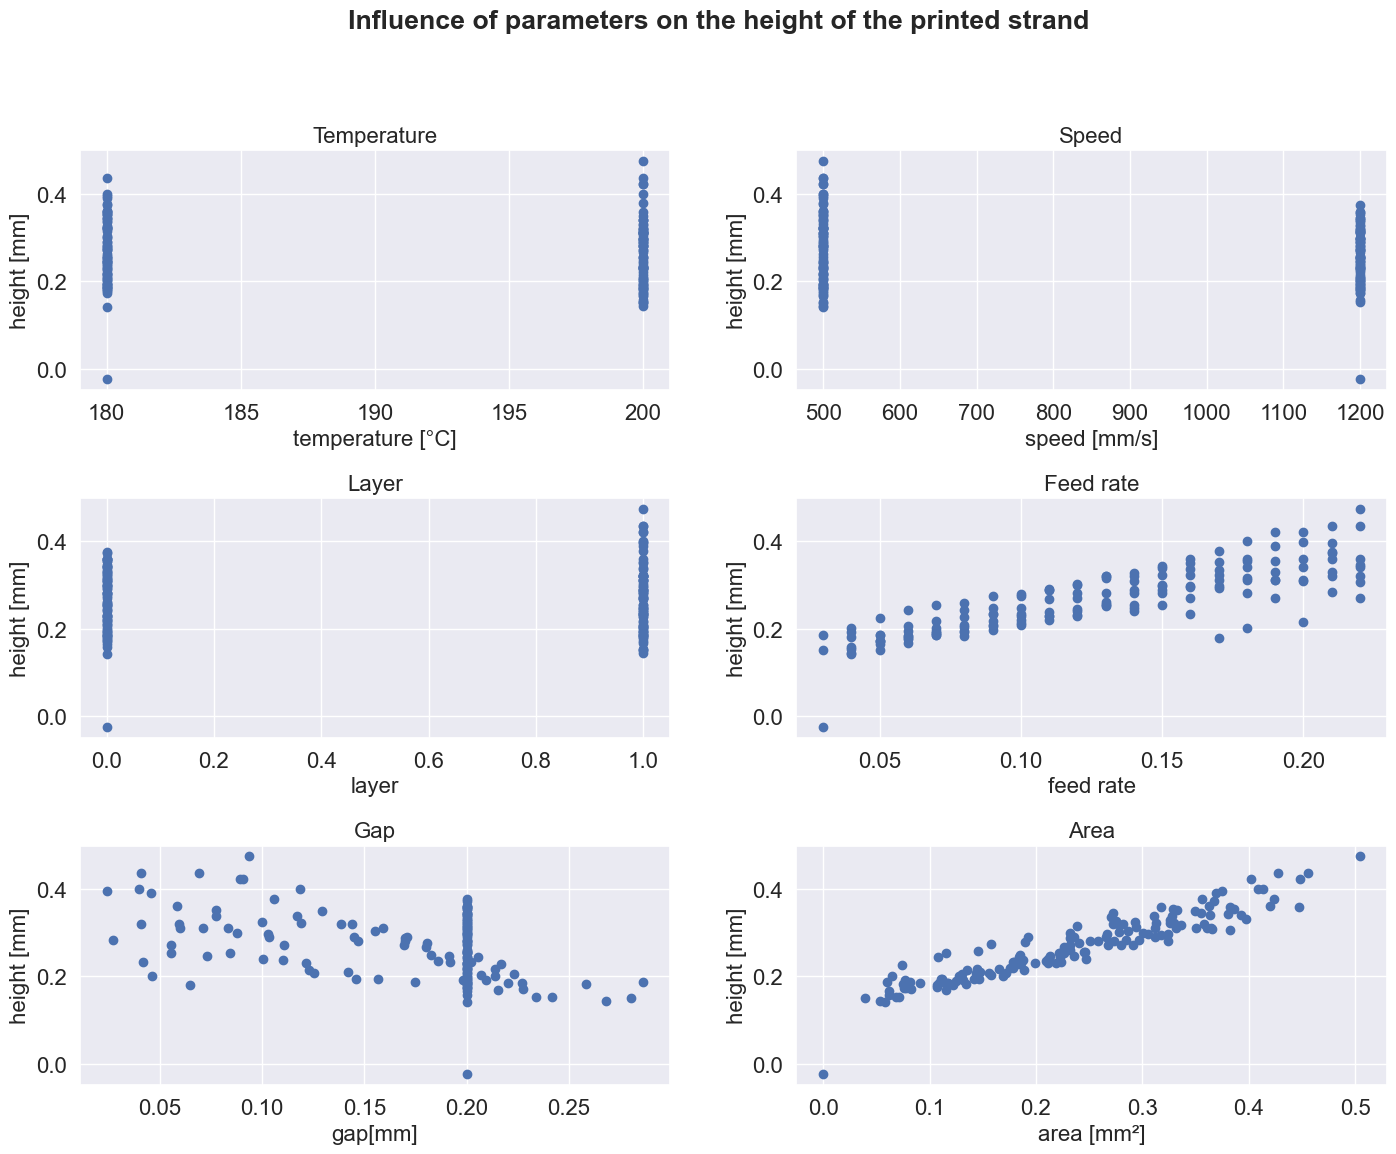

In [36]:
eval = "height"
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle("Influence of parameters on the height of the printed strand", weight="bold")
fig.tight_layout(pad=3.0)
for i, (param, unit) in enumerate(zip(["temperature", "speed", "layer", "feeding_rate", "gap", "area"], [' [°C]', ' [mm/s]', '', '', '[mm]', ' [mm²]'])):
    axes[i//2, i%2].plot(df[param], df[eval], 'o')
    if param == 'feeding_rate': param = 'feed rate'
    axes[i//2, i%2].title.set_text(f'{param[0].upper()}{param[1:]}')
    axes[i//2, i%2].set_xlabel(f"{param}{unit}")
    axes[i//2, i%2].set_ylabel(f"{eval} [mm]")

## Basic features

In [37]:
from sklearn.preprocessing import PolynomialFeatures

polyreg = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression())])

polyreg = polyreg.fit(X[df.layer != 0], height[df.layer != 0])
pred = polyreg.predict(X)
r2 = r2_score(height, pred)
print(f"Linear Regression r^2 on test data : {r2:.3f}")
print(f"Prediction: {pred[0][0]}\nReal value: {height[0][0]}")

Linear Regression r^2 on test data : -21013005883.420
Prediction: 0.18622350017540157
Real value: 0.1867976188659668


## Feature Engineering

**Hypothesis**:
* Parameters with low coefficients can be removed from the model

In [38]:
from sklearn.preprocessing import FunctionTransformer

def height_features(X:np.ndarray) -> np.ndarray:
    temperature, speed, feeding_rate, layer, gap, width, area = X[:, 0], X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5], X[:, 6]
    fw = feeding_rate / width
    sqrtf = np.sqrt(feeding_rate)
    w2 = width ** 2
    sqrtfw = np.sqrt(fw)
    return np.column_stack([feeding_rate, temperature, speed, np.cbrt(feeding_rate)])

HeightFeatures = FunctionTransformer(height_features)

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

height_model = Pipeline([('transf', HeightFeatures),
                  ('linear', LinearRegression())])
# fit to an order-3 polynomial data
height_model = height_model.fit(X[df.layer != 0], height[df.layer != 0])
pred = height_model.predict(X[df.layer != 0])
r2 = r2_score(height[df.layer != 0], pred)
print(f"Linear Regression r^2 on test data : {r2:.3f}")
print(f"Prediction: {pred[0][0]}\nReal value: {height[0][0]}")

Linear Regression r^2 on test data : 0.801
Prediction: 0.16186860238094286
Real value: 0.1867976188659668


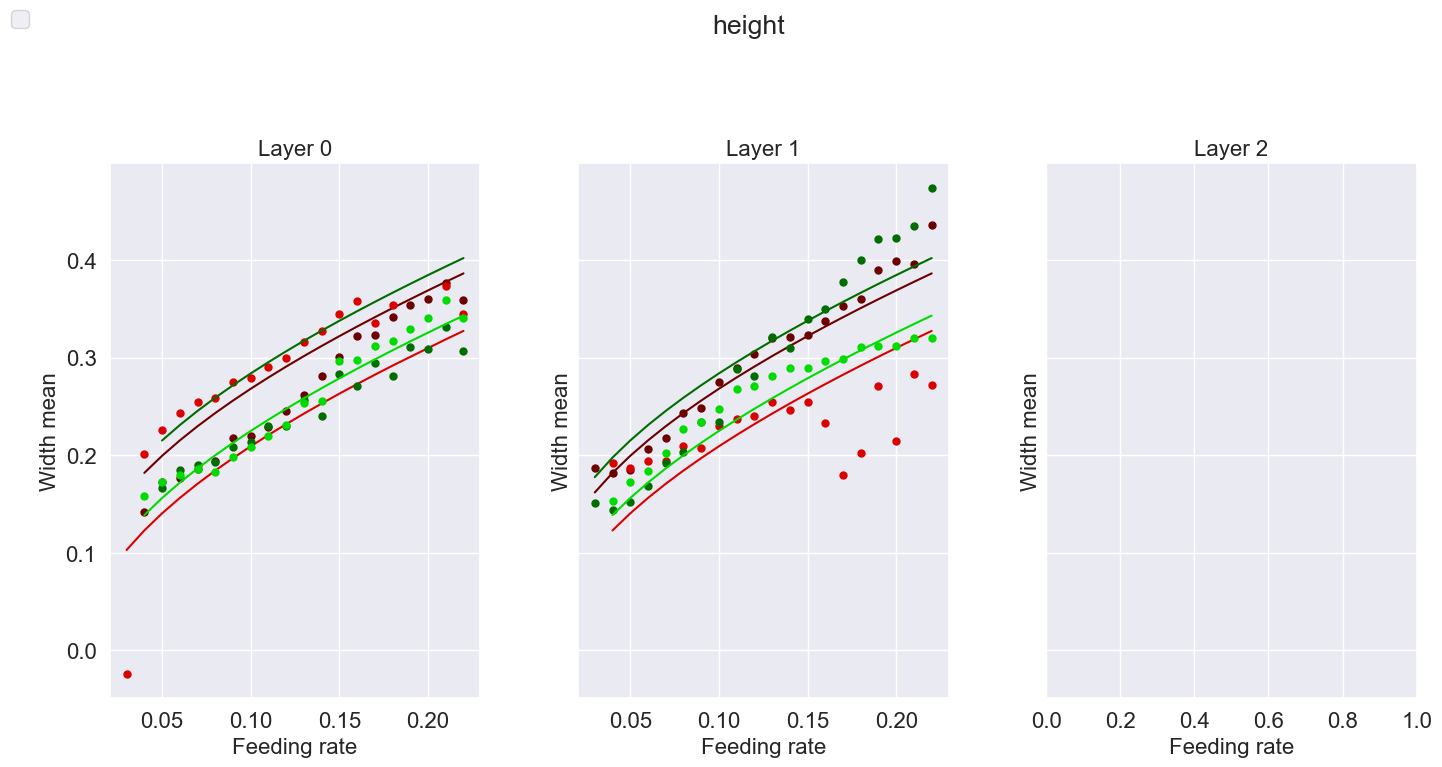

In [40]:
eval = "height"
fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharey=True)
fig.suptitle(eval)
fig.tight_layout(pad=3.0)

for layer in [0, 1, 2]:
    for temp_no, temperature in enumerate([180, 200]):
        for speed_no, speed in enumerate([500, 700, 1000, 1200]):
            color_base = np.zeros((3,))
            color_base[temp_no] = 1
            current = df[(df.temperature == temperature) & (df.speed == speed) & (df.layer == layer)]
            if len(current) == 0: continue
            axes[layer].plot(current["feeding_rate"], current[eval], 'o', markersize=5, color=color_base * ((3 + speed_no) / 7), label=f"temp {temperature} speed {speed}")#+ np.array([0, 0, 1]) * speed_no / 4)
            predictions_mean = []
            for fr in np.unique(current["feeding_rate"]):
                current_fr = current[current.feeding_rate == fr]
                params = current_fr[["temperature", "speed", "feeding_rate", "layer", "gap", "width", "area"]].values.mean(axis=0)
                predictions_mean.append(height_model.predict(params.reshape(1, -1))[0])
            axes[layer].plot(np.unique(current["feeding_rate"]), predictions_mean, color=color_base * ((3 + speed_no) / 7), label=f"temp {temperature} speed {speed}")#+ np.array([0, 0, 1]) * speed_no / 4
    axes[layer].title.set_text(f"Layer {layer}")
    axes[layer].set_xlabel("Feeding rate")
    axes[layer].set_ylabel("Width mean")
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')

### Model based on ellipse formula

In [41]:
def geometry_model(X:np.ndarray) -> np.ndarray:
    temperature, speed, feeding_rate, layer, gap, w, area = X[:, 0], X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5], X[:, 6]
    # w = width_model.predict(X)
    # area = area_model.predict(X)
    delta = w ** 2 * (np.pi**2 + 8*np.pi + 16) + 32 * 0.9 * area * (np.pi - 4)
    b = w * (np.pi + 4)
    denominator = 8 - 2 * np.pi
    h = (b - np.sqrt(delta)) / denominator
    return np.column_stack([h])

GeometryFeatures = FunctionTransformer(geometry_model)

height_model = Pipeline([('transf', GeometryFeatures),
                  ('linear', LinearRegression())])
# fit to an order-3 polynomial data
height_model = height_model.fit(X, height)
pred = height_model.predict(X)
r2 = r2_score(height, pred)
print(f"Linear Regression r^2 on test data : {r2:.3f}")
print(f"Prediction: {pred[0][0]}\nReal value: {height[0][0]}")

Linear Regression r^2 on test data : 0.975
Prediction: 0.18659585343559454
Real value: 0.1867976188659668


In [42]:
print_coefs_and_params_names(height_model, ['h'])

Coefficients:
h: 1.1091118401975177
intercept: -0.023084143477631602


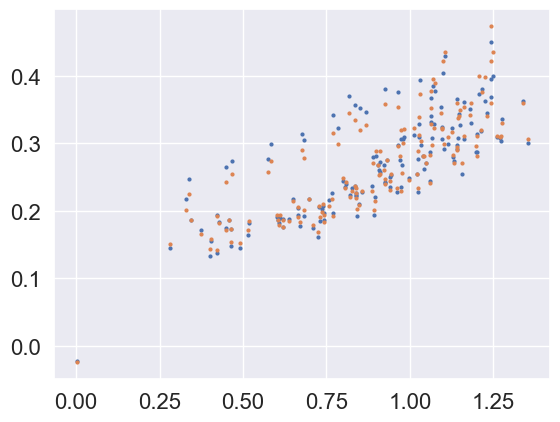

In [43]:
markersize = 2
plt.plot(df.width, pred, 'o', markersize=markersize)
plt.plot(df.width, height, 'o', markersize=markersize)

## Conclusions

Height can be calculated with the analytical model of the ellipse, varying with the width and the area. However, if the parameters passed to it are the predictions, i.e. the models of area and width, the height prediction presents a high error, probably due to a combination of errors in the area and width models.

The area model, though, has a multiplier, probably because the format may vary.

# Area model

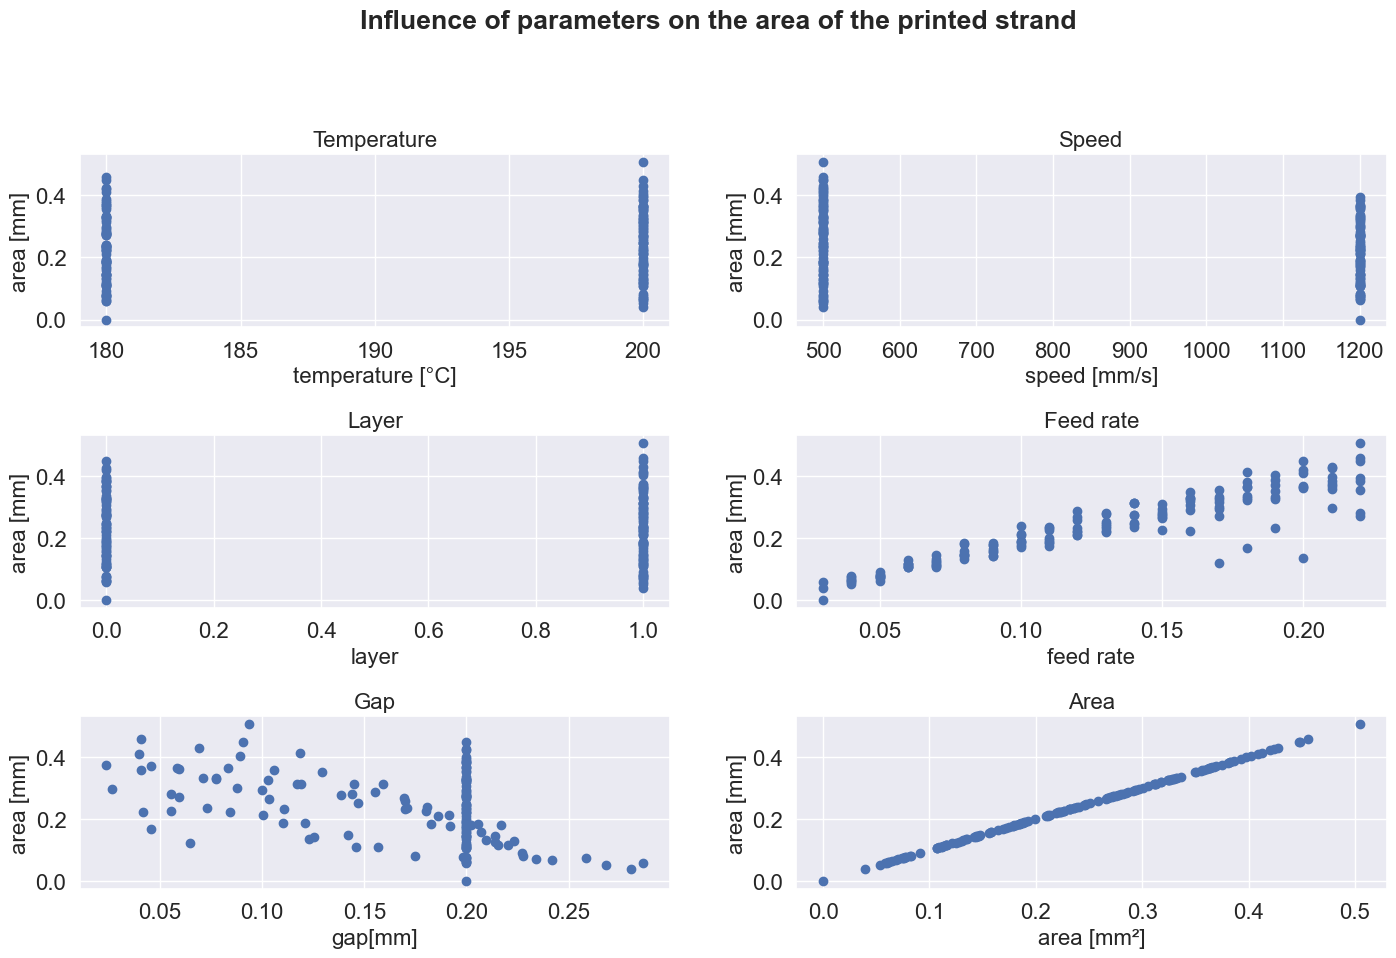

In [44]:
eval = "area"
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle("Influence of parameters on the area of the printed strand", weight="bold")
fig.tight_layout(pad=3.0)
for i, (param, unit) in enumerate(zip(["temperature", "speed", "layer", "feeding_rate", "gap", "area"], [' [°C]', ' [mm/s]', '', '', '[mm]', ' [mm²]'])):
    axes[i//2, i%2].plot(df[param], df[eval], 'o')
    if param == 'feeding_rate': param = 'feed rate'
    axes[i//2, i%2].title.set_text(f'{param[0].upper()}{param[1:]}')
    axes[i//2, i%2].set_xlabel(f"{param}{unit}")
    axes[i//2, i%2].set_ylabel(f"{eval} [mm]")

In [45]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

def area_features(X:np.ndarray) -> np.ndarray:
    temperature, speed, feeding_rate, layer, gap, w, area = X[:, 0], X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5], X[:, 6]
    fr2 = feeding_rate ** 2
    t_f = temperature * feeding_rate
    s_f = speed * feeding_rate
    sqrt = np.sqrt(feeding_rate)
    w2 = w ** 2
    return np.column_stack([feeding_rate])

AreaFeatures = FunctionTransformer(area_features)

area_model = Pipeline([('transf', AreaFeatures),
                  ('linear', LinearRegression())])
# fit to an order-3 polynomial data
area_model = area_model.fit(X, area)
pred = area_model.predict(X)
r2 = r2_score(area, pred)
print(f"Linear Regression r^2 on test data : {r2:.3f}")
print(f"Prediction: {pred[0][0]}\nReal value: {area[0][0]}")

Linear Regression r^2 on test data : 0.843
Prediction: 0.056961687306011956
Real value: 0.0600707403988143


In [46]:
print_coefs_and_params_names(area_model, coef_names = ['feeding_rate', 'fr2'])

Coefficients:
feeding_rate: 1.812969202377806
intercept: 0.0025726112346777796


The volume measured does not match the theoretical volume calculated by the E parameter of the gcode.

In [47]:
area_ratio = (df.feeding_rate * np.pi * 1.75**2 / 4) / df.area - 1
area_ratio = area_ratio[~np.isinf(area_ratio)]
area_ratio.mean()

0.3608385656749022